In [1]:
import pandas as pd  # pandas 0.22
import numpy as np
import re
import matplotlib.pyplot as plt

## 1-) Extract CPS data.

The extraction code is based on code provided by Brian Dew. See: https://www.bd-econ.com/cps.html for details.
I introduce a for loop to convert raw datasets for each month into pandas dataframe at once. I use CPS data from 2018.

In [2]:
dd_file = 'jan07dd.txt'
dd_full = open(dd_file, 'r', encoding='iso-8859-1').read()

# Variables that we are interested in:
series = ['HRHHID','HRHHID2','HRMONTH','PEAGE','PUERNH1C','PRWKSTAT','PEMLR',
         'PEIO1COW','PEIO2COW','PEABSRSN','HRMIS','PULINENO',]

p = re.compile('\n(\w+)\s+(\d+)\s+(.*?)\s+\((\d\d*).*?(\d\d+)\)')

dd_sel_var = [(i[0], int(i[3])-1, int(i[4])) 
              for i in p.findall(dd_full) if i[0] in series]

In [3]:
set_month=['dec17pub','jan18pub','feb18pub','mar18pub','apr18pub',
           'may18pub','jun18pub','jul18pub','aug18pub',
           'sep18pub','oct18pub','nov18pub','dec18pub']

set_df=[] 
for i in set_month:
    data = [tuple(int(line[i[1]:i[2]]) for i in dd_sel_var) 
            for line in open('CPS_datasets/%s.dat' % i, 'rb')]
    
    globals()['%s' % i] = pd.DataFrame(data, columns=[v[0] for v in dd_sel_var])
    set_df.append(globals()['%s' % i])

#set_df is the list of CPS datasets.
    

## Tracking households across different files.

In below code, I write a function which tracks people who went to state of employment to unemployment in a month.

The method can be described as follows:

Suppose we consider month M and want to estimate the EU rate between M and M+1. df1 is the basic CPS dataset of month M and df1 is the dataset of M+1. Given that households with survey months of 4 and 8 will not be in the next month's CPS, we exclude them from df1. Similarly, households with survey months of 1 and 5 in M+1 are either entering the sample for the first time or returnin; hence, they are excluded as they will not be in M. 
We also impose age and labor force restrictions.

I do not consider self-employed people when considering rates from employment to unemployment. To that regard, I create three dummies: people employed, self-employed and unemployed in df1. A person whose first and/or second jobs are self-employed will be considered as self-employed. 




In [4]:
def new_list(set_df):
    """
    Input:
        set_df is the vector of names of the basic montly CPS datasets.
    returns:
        A vector of employment to unemployment rate for each month (i.e. each CPS month)
    """
    EU_list=[]
    for i in range(1,len(set_df)):

        df1=set_df[i-1][(set_df[i-1]['HRMIS']!=4)& (set_df[i-1]['HRMIS']!=8)]
        df2=set_df[i][(set_df[i]['HRMIS']!=1)& (set_df[i]['HRMIS']!=5)]
        #We limit the data to include individuals who are active in labor force: PEMLR is between 0 and 5.
        #We limit the data to include individuals aged between 18 and 75.
        df1=df1[(df1['PEAGE']<75) & (df1['PEAGE']>18) & (df1['PEMLR']<5) & (df1['PEMLR']>0) ]
        
        #Dummy variables for employment status for month M
        df1['self-employed']=np.where(((df1['PEIO1COW']==7) | (df1['PEIO1COW']==6) 
                                        | (df1['PEIO2COW']==7) | (df1['PEIO2COW']==6)) &
                                        ((df1['PEMLR']==1) | (df1['PEMLR']==2)),1,0)
        
        df1['employed']=np.where(((df1['PEMLR']==1) | (df1['PEMLR']==2)) & (df1['self-employed']==0),1,0)
        df1['unemployed']=np.where((df1['PEMLR']==3) | (df1['PEMLR']==4),1,0)
        
        #Dummy variables for employment status for month M +1
        df2['self-employed']=np.where(((df2['PEIO1COW']==7) | (df2['PEIO1COW']==6) 
                                        | (df2['PEIO2COW']==7) | (df2['PEIO2COW']==6)) &
                                        ((df2['PEMLR']==1) | (df2['PEMLR']==2)),1,0)
        
        df2['employed']=np.where(((df2['PEMLR']==1) | (df2['PEMLR']==2)) & (df2['self-employed']==0),1,0)
        df2['unemployed']=np.where(((df2['PEMLR']==3) | (df2['PEMLR']==4)),1,0)
        
        #Create a new variable that takes value of 1 if a person is employed, 2 if unemployed and 3 if self-employed 
        conditions = [(df2['employed'] == 1),
                      (df2['unemployed'] == 1),(df2['self-employed'] == 1)]

        choices = [1,2,3]

        df2['labor_status']=np.select(conditions, choices, default='NA')
        #Merge employed people in month M with the second data
        #While merging take keys of household identifiers and person's line number (w/i household)
        df_merge=pd.merge(df1[(df1['employed']==1)], df2, on=['HRHHID','HRHHID2','HRHHID','PULINENO'])
        #Count rows where employed people in M are unemployed in M+1 and take the ratio.
        emp_to_unemp=df_merge[df_merge['labor_status']=='2'].shape[0]
        x=emp_to_unemp/df_merge.shape[0]
        EU_list.append(x)
    return(EU_list)






In [5]:
pd.options.mode.chained_assignment = None
EU_list=new_list(set_df)

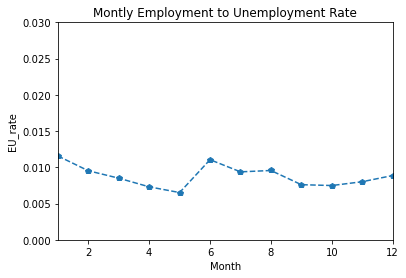

In [6]:
plt.plot(list(range(1,13)),EU_list,'p--')
plt.axis([1, 12,0,0.03])
plt.xlabel("Month")
plt.ylabel("EU_rate")
plt.title("Montly Employment to Unemployment Rate")
plt.show()

In [7]:
mean_=np.mean(EU_list)
print(f"The average rate from employment to unemployment is {round(mean_,4)}")

The average rate from employment to unemployment is 0.0088
